# Notes for MACS 30123
-----------------------

## Lecture 1
Mar. 24

Compiling Python with `numba` and `cython`

compile python function(script) and compute the running time

* `numba`
* `cython`



### Using `numba`

#### `%time` and `jit`
`from numba import jit `

从 `numba` 库中导入 `jit` 装饰器（just-in-time 编译器）；

它可以用来**加速数值计算中的 Python函数**，使其像C一样高效；

适用于大量循环、数组操作等CPU密集型运算。

In [1]:
from numba import jit

# jit compiles when we call the function for the first time
# nopython tries to run without involving Python interpreter
@jit(nopython=True)
def loop_jit(x, r):
  for i in range(r):
    x *= 2.5
  return x

%time loop_jit(2, 10**6) # The first time includes compilation time

CPU times: user 257 ms, sys: 71.7 ms, total: 329 ms
Wall time: 1.17 s


inf

In [3]:
import random

def lambda_handler(event, context):
    # placeholder for large, compute-intensive summarization operation
    n_runs = 10**7
    sim = [random.random() for _ in range(n_runs)]
    summary = sum(sim) / n_runs

    # return result to participant
    return summary

%timeit lambda_handler({}, {})

736 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
%time loop_jit(2, 10**6) # much faster after compilation

CPU times: user 2.76 ms, sys: 14 μs, total: 2.78 ms
Wall time: 2.78 ms


inf

In [3]:
%timeit loop_jit(2, 10**6) # %timeit runs the code multiple times and gives the average time

2.06 ms ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
def loop(x, r):
    for i in range(r):
        x *= 2.5
    return x

%time loop(2, 10**6)
%timeit loop(3, 10**6) # better to time across multiple runs using `timeit`

CPU times: user 32.3 ms, sys: 2.04 ms, total: 34.4 ms
Wall time: 37.2 ms
30.4 ms ± 849 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### `CC`
We might want to **compile our code ahead of time**, though, so that we can see a speed-up the first time we use it. `numba` allows us to compile ahead of time like so:

CC的作用是将一个函数 loop_aot 预先编译成一个二进制模块（.so 或 .dll 文件），而不是在运行时即时（JIT）编译。

In [7]:
from numba.pycc import CC

# name of compiled module to create:
cc = CC('test_aot')
# 创建一个编译上下文，模块名称为 test_aot；
# 最终会生成一个名为 test_aot.so（Linux/macOS）或 test_aot.pyd（Windows）的共享库文件


# name of function in module, with explicit data types required (4byte=32bit ints and floats)
@cc.export('loop_aot', 'f4(f4,i4)')
def loop_aot(x, r):
    for i in range(r):
        x *= 2.5
    return x

cc.compile()

ld: warning: duplicate -rpath '/opt/anaconda3/lib' ignored
ld: warning: object file (/private/var/folders/4g/6_8lhyp147394q93651p5kyw0000gn/T/pycc-build-test_aot-tpfi5526/test_aot.cpython-312-darwin.o) was built for newer 'macOS' version (15.0) than being linked (11.0)



一、签名字符串 `'f4(f4, i4)'` 含义：

Numba 的 `@cc.export('func_name', 'signature')` 中，**函数签名（signature）格式如下**：

\[
\texttt{'<返回值类型>(<参数1类型>, <参数2类型>, ...)'}
\]

所以：

```python
@cc.export('loop_aot', 'f4(f4,i4)')
```

表示：

- `loop_aot` 是导出的函数名；
- `'f4(f4,i4)'` 的含义是：
  - `f4`：表示函数的**返回值类型是 float32**；
  - `(f4, i4)`：表示函数的**参数分别是 float32 和 int32**。

---

二、常见类型缩写对照表：

| 缩写 | 类型        | 对应 Python 类型         |
|------|-------------|--------------------------|
| `i4` | int32       | `numpy.int32` / `int`    |
| `i8` | int64       | `numpy.int64` / `int`    |
| `f4` | float32     | `numpy.float32` / `float`|
| `f8` | float64     | `numpy.float64` / `float`|
| `b1` | boolean     | `bool`                   |
| `void` | 无返回值 | `None`                   |

---

三、可以导出多个函数吗？

**当然可以！你可以用多个 `@cc.export` 来导出多个函数。**

例如：

```python
@cc.export('loop_aot', 'f4(f4,i4)')
def loop_aot(x, r):
    for i in range(r):
        x *= 2.5
    return x

@cc.export('square_add', 'f8(f8, f8)')
def square_add(a, b):
    return a**2 + b**2
```

然后编译：

```python
cc.compile()
```

就会在模块中同时生成 `loop_aot` 和 `square_add` 两个函数，可以在 Python 中这样使用：

```python
import test_aot

print(test_aot.loop_aot(1.0, 3))      # 输出：1.0 * 2.5^3
print(test_aot.square_add(3.0, 4.0))  # 输出：3² + 4² = 25.0
```

---

四、如何写更复杂的类型？

Numba 也支持：

- 向量、数组参数（比如 `'void(f8[:])'` 表示传入一个 1D float64 数组）
- 多维数组、结构体、tuple（更复杂）

如果你想加速处理 `numpy` 向量数据，可以写：

```python
@cc.export('scale_array', 'void(f4[:], f4)')
def scale_array(arr, a):
    for i in range(len(arr)):
        arr[i] *= a
```

---

##### Details for `CC`

1. **@cc.export 必须紧贴函数定义前一行写**

`@cc.export(...)` 是一个 **装饰器（decorator）**，必须**紧跟它所要装饰的函数定义**，否则 Python 解释器无法把它和对应函数关联起来。

```python
@cc.export('loop_aot', 'f4(f4,i4)')
def loop_aot(x, r):
    ...
```
错误示例（中间插入其他代码）：

```python
@cc.export('loop_aot', 'f4(f4,i4)')
print("hello")  # 错误：装饰器失效
def loop_aot(x, r):
    ...
```
---

2. **可以为同一个函数写多个 `@cc.export(...)` **

可以对**同一个函数定义导出多个不同签名（overload）**，只要你的函数能接受这些类型并正确工作。

```python
@cc.export('loop_aot', 'f4(f4,i4)')
@cc.export('loop_aot', 'f8(f8,i4)')  # 支持 float64 输入
def loop_aot(x, r):
    for i in range(r):
        x *= 2.5
    return x
```

这里的两个 `@cc.export` 都作用在 **同一个函数 `loop_aot` 上**，最终在模块中导出一个 `loop_aot`，支持两种类型输入：`float32` 和 `float64`。

你不能这样写：

```python
@cc.export('loop_aot', 'f4(f4,i4)')
@cc.export('another_name', 'f8(f8,i4)')
def loop_aot(x, r):
    ...
```

因为你不能用两个 export 给**不同名字**，但只写一个函数定义。要想给不同名字写 export，必须写不同函数名。

---



Note that we now have a compiled object file (.so) in our current directory. This is a compiled module that contains our function.

In [8]:
ls

LICENSE                         notes30123.ipynb
README.md                       test_aot.cpython-312-darwin.so*
in-class-activities/


To use our function, we just need to import our pre-compiled module, as we would any other Python module:

In [10]:
import test_aot
%time test_aot.loop_aot(2, 10**6) # first time running it is fast this time
%timeit test_aot.loop_aot(2, 10**6) # same overall performance as before

CPU times: user 2.17 ms, sys: 347 µs, total: 2.52 ms
Wall time: 2.77 ms
2.06 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Using `cython`

Another common way to compile Python code (albeit slightly uglier) is to compile our function via explicit `cython` static typing, like so (here, using the IPython `cython` extension to compile):

In [19]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [21]:
%%cython

cpdef double loop_cython(double x, int r):
    cdef int i
    for i in range(r):
        x *= 2.5
    return x


Content of stderr:
ld: warning: duplicate -rpath '/opt/anaconda3/lib' ignored

In [20]:
# will automatically convert Python -> C -> Compiled machine code
%%cython

# explicitly add static types to function itself:
def loop_cython(float x, int r):
    cdef int i
    for i in range(r):
        x *= 2.5
    return x

SyntaxError: invalid syntax (1063832235.py, line 5)

In [22]:
%timeit loop_cython(2, 10**6) # comparable performance to numba

2.06 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Lecture 2

Mar. 26

Parallel Programming



## Speedup Laws

这两个法则——Amdahl's Law 和 Gustafson's Law——都是并行计算中衡量加速潜力（speedup）的核心理论，但它们的假设前提和适用场景不同。

### Amdahl's Law Speedup

$$\frac{1}{S + \frac{P}{N}}$$

- P = Parallel Fraction of Work
- S = Serial Fraction of Work 
- N = Number of Processors 

Amdahl's Law（阿姆达尔定律）

- S：程序中不可并行的部分（串行 fraction）
- P：可并行的部分（并行 fraction，
- N：处理器数量

核心思想：
程序中那一小部分串行任务限制了整体加速能力，哪怕你用再多处理器。

举例：
即使 99% 可以并行（S=0.01），加速上限最多也只有 100 倍。

适用场景：
强调固定问题规模（Fixed-size scaling）——即任务总量不变，只是用更多处理器来加速。

### Gustafson's Law Scaled Speedup
  
$$N - S \times (N - 1)$$


核心思想：
如果我们随着处理器数量的增加而扩大任务规模（即数据量更大），那么并行部分就会占比更高，总体加速就更可观。

适用场景：
强调弱扩展性（Weak scaling）——随着处理器变多，你可以处理更大的问题。

## CPUS AND COMPUTING CLUSTERS: HARDWARE CONSIDERATIONS

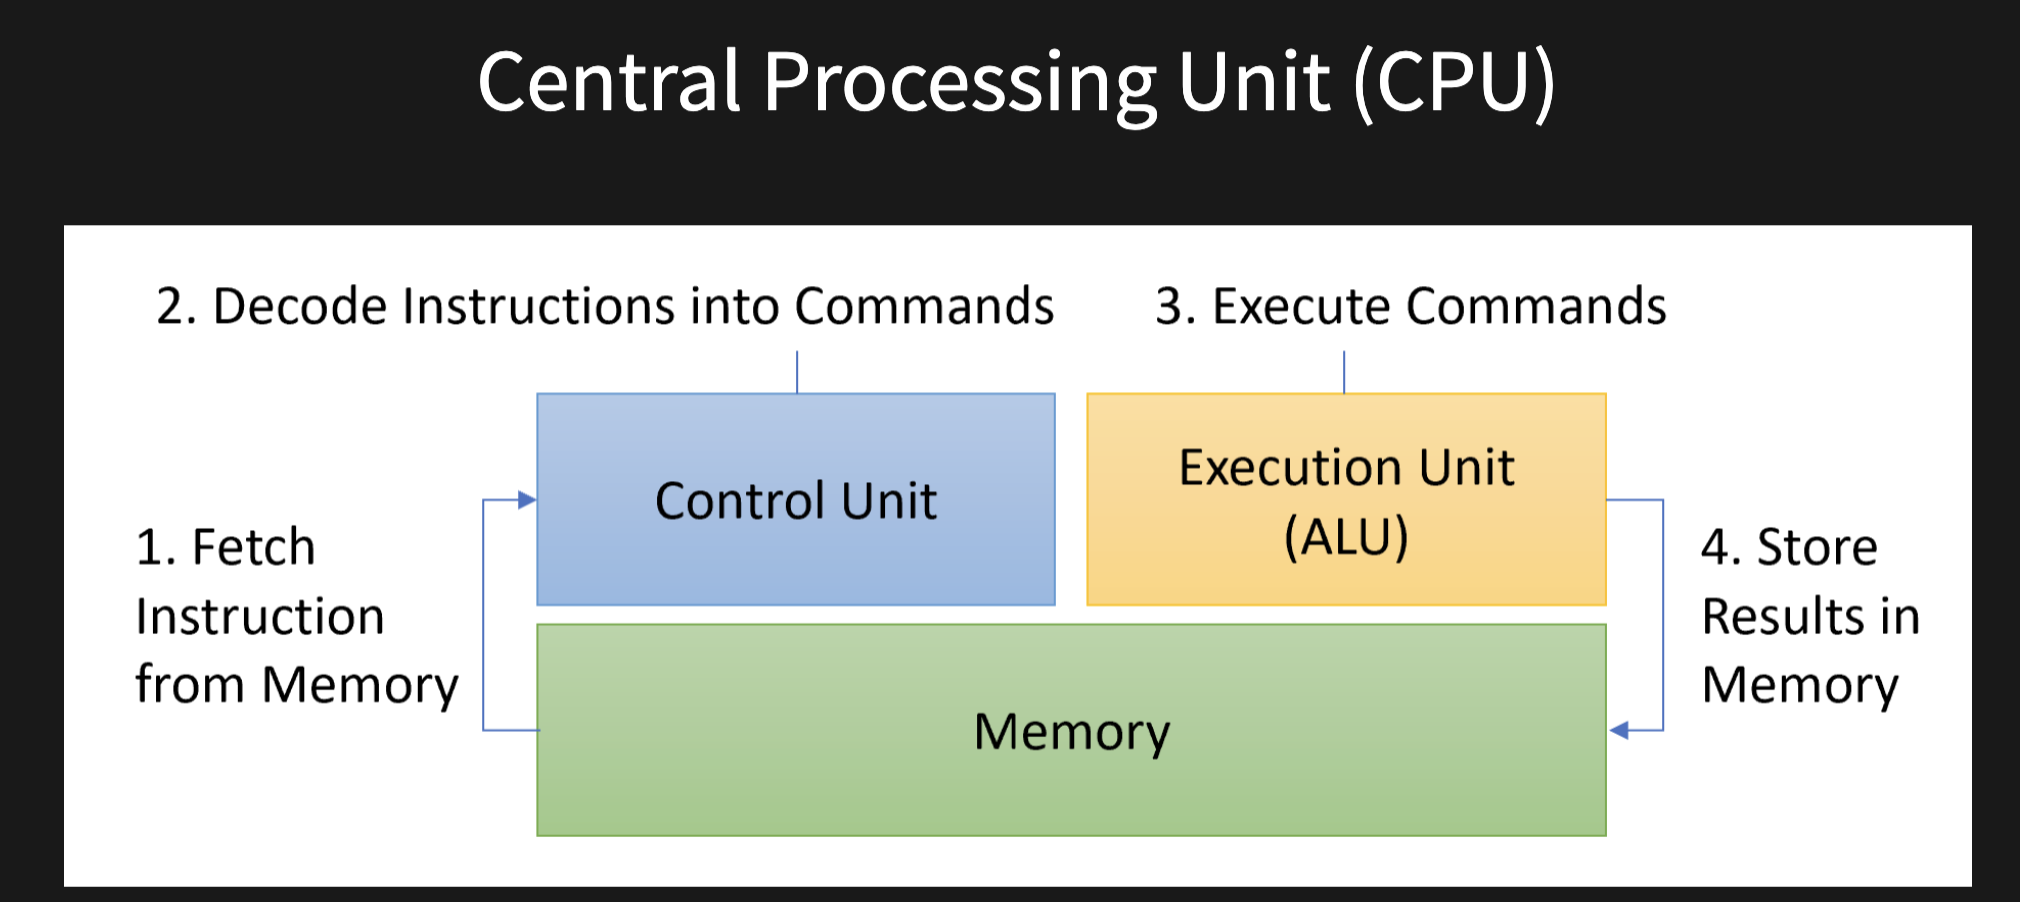

![alt text](image.png)


### Calculating Peak Performance

计算机峰值性能（Peak Performance）

$$
\text{FLOP/s} = \text{Cores} \times \text{Hertz/Core} \times \text{FLOPs/Cycle}
$$


- **Cores**：处理器核心数量（如 32 核 CPU）
- **Hertz/Core**：每个核心的主频（单位是 Hz，比如 2.5 GHz = \(2.5 \times 10^9\) cycles/sec）
- **FLOPs/Cycle**：每个时钟周期内，每个核心能执行的**浮点运算次数**

这个乘积给出的就是处理器每秒能完成的**浮点数运算次数（FLOP/s）**，即**理论峰值性能**。

假设：
- 16 核
- 每核 2.5 GHz
- 每个周期能做 8 次浮点操作（如使用 AVX）

那么：
$\text{FLOP/s} = 16 \times 2.5 \times 10^9 \times 8 = 320 \times 10^9 = 320 \text{ GFLOP/s}$

* Memory Bottleneck Takeaways
    - Keep your data close to your CPU
    - Increase the size of your faster memory sources, if necessary



### Working on a Computing Cluster

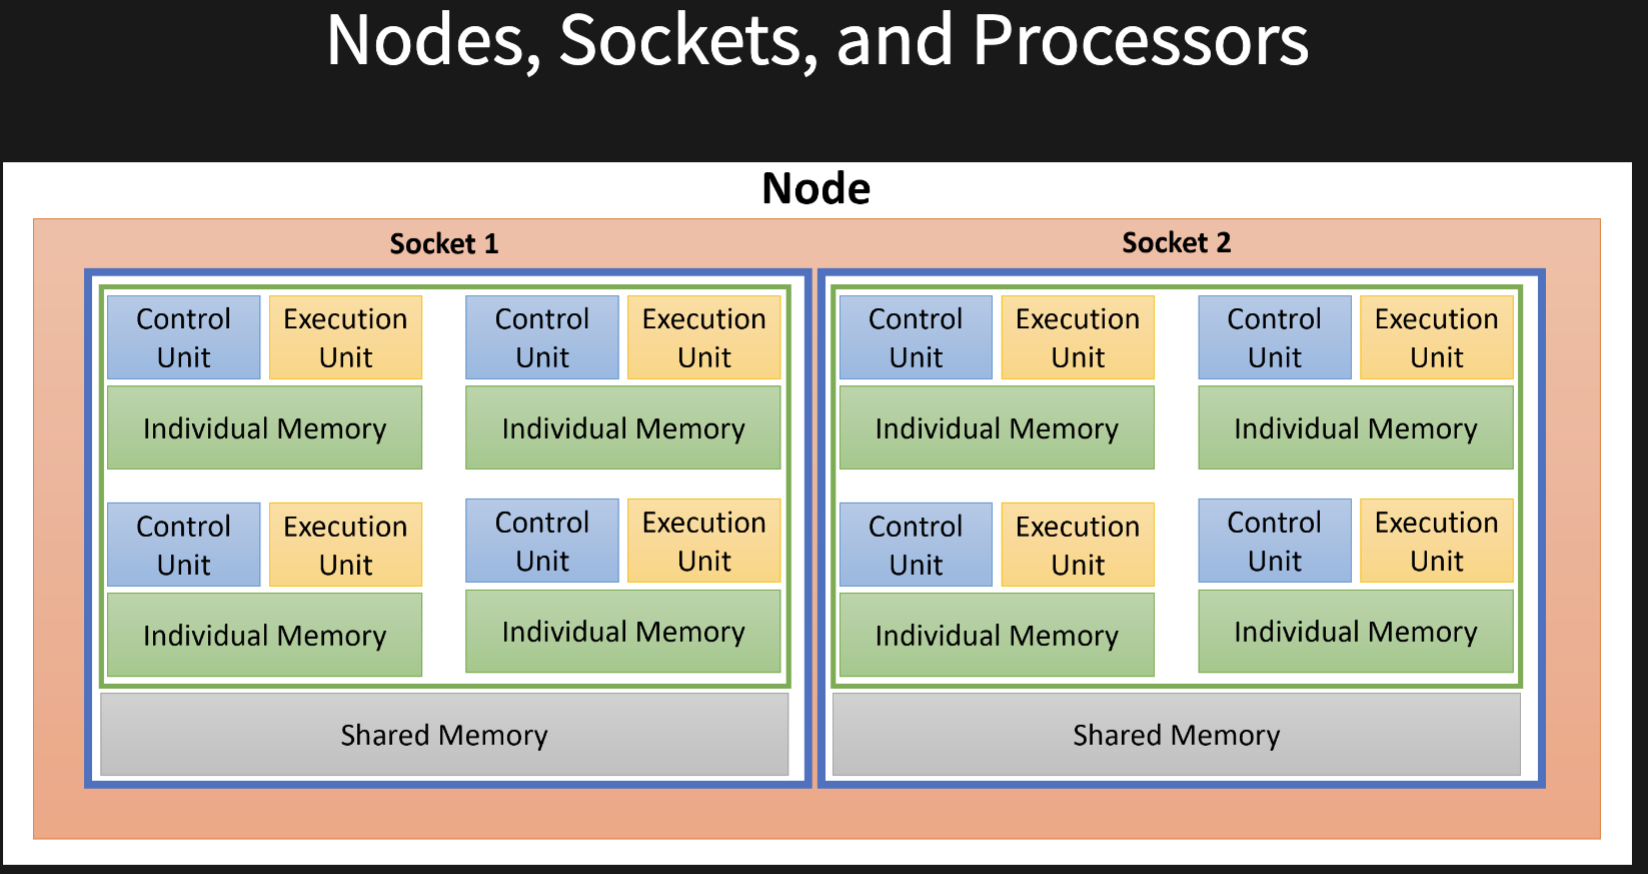

# Lecture 3

Mar. 31

CPU Parallelism

how you can achieve parallel execution on CPUs by way of vector processing and multi-threading, using `numba`. 

## CPU Parallelism: Vector Processing and Multithreading

how you can achieve parallel execution on CPUs by way of vector processing and multi-threading, using `numba`. Here, we'll focus on incorporating `numba` into a common analytical workflow -- that of applying some function to a column (or several columns) in your DataFrame and creating a new, derived column for further study.

For this demonstration, we'll be working with a small sample of [AirBnB's listing data](http://insideairbnb.com/get-the-data.html), a large dataset that contains information on AirBnBs from around the world on a month-by-month basis.

In [4]:
from numba.pycc import CC
from numba import vectorize, jit, prange
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv('in-class-activities/02_Midway_CPU/CPU_Intro/listings_chi.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,65,2,182,2021-03-28,2.38,1,0
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85373,-87.69540,Entire home/apt,113,2,395,2020-07-14,2.67,1,180
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90166,-87.68021,Entire home/apt,65,2,394,2021-04-11,2.74,1,267
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91943,-87.63898,Entire home/apt,120,5,54,2021-01-15,0.63,11,1
4,10945,The Biddle House (#1),33004,At Home Inn,NaN,Lincoln Park,41.91196,-87.63981,Entire home/apt,175,4,22,2021-03-25,0.26,11,125


In [8]:
macss = {'longitude': -87.5970978, 'latitude': 41.7856443}

We'll write another version of this function that uses `numba` to compile this function ahead of time in two ways: one that performs the calcuation on individual scalar values and another that does so via vector processing.

In [9]:
def distance(lon1, lat1, lon2, lat2):
    '''                                                                         
    Calculate the circle distance between two points                            
    on the earth (specified in decimal degrees)                                 
    '''
    # convert decimal degrees to radians                                        
    lon1, lat1 = map(np.radians, [lon1, lat1])
    lon2, lat2 = map(np.radians, [lon2, lat2])

    # haversine formula                                                         
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    # 6367 km is the radius of the Earth                                        
    km = 6367 * c
    m = km * 1000
    return m

# Use Numba to compile this same function in a module named `aot`
# in both a vectorized and non-vectorized form
cc = CC('aot')

@cc.export('distance', 'f8(f8,f8,f8,f8)')
@cc.export('distance_v', 'f8[:](f8[:],f8[:],f8,f8)')
def distance_numba(lon1, lat1, lon2, lat2):
    '''                                                                         
    Calculate the circle distance between two points                            
    on the earth (specified in decimal degrees)
    
    (distance: Numba-accelerated; distance_v: Numba-accelerated + vectorized)
    '''
    # convert decimal degrees to radians                        
    lon1, lat1 = map(np.radians, [lon1, lat1])
    lon2, lat2 = map(np.radians, [lon2, lat2])

    # haversine formula                                                         
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    # 6367 km is the radius of the Earth                                        
    km = 6367 * c
    m = km * 1000
    return m
cc.compile()

import aot # import in module we just compiled

ld: warning: duplicate -rpath '/opt/anaconda3/lib' ignored
ld: warning: object file (/private/var/folders/4g/6_8lhyp147394q93651p5kyw0000gn/T/pycc-build-aot-mc52ala9/aot.cpython-312-darwin.o) was built for newer 'macOS' version (15.0) than being linked (11.0)


First, we could use the common dataframe method `apply` to apply our function to each row in our dataframe. Note, though, that **this is really slow and is effectively equivalent to looping over each row in the dataframe using our pre-compiled distance function.**

In [10]:
%%timeit
df.loc[:,'distance_from_macss'] = df[['longitude', 'latitude']] \
                                    .apply(lambda x: distance(x.longitude,
                                                              x.latitude,
                                                              macss['longitude'],
                                                              macss['latitude']),
                                           axis=1)

111 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
distance_lst = []
for lon, lat in df[['longitude', 'latitude']].values:
  dist = distance(lon,
                  lat,
                  macss['longitude'],
                  macss['latitude'])
  distance_lst.append(dist)
df.loc[:,'distance_from_macss'] = distance_lst
# see that this solution is essentially the same!

58.2 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
